In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
from google.colab import drive as cdrive
from keras.preprocessing.image import save_img

cdrive.mount('/content/gdrive')


# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

########### Load labels for the tiny_dataset ####################3
df_full = pd.read_csv('gdrive/My Drive/stage_2_train.csv')

#Only get the labels with "any" brain hemmorage
df_full = df_full[df_full.ID.str.endswith('_any')]

#Find the labels in the csv from the file names in the folder
image_path = Path("gdrive/My Drive/tiny_dataset/png")
ID = []
for f in list(image_path.glob('**/*.png')):
    ID.append(os.path.split(f)[-1][:-4] + "_any")

#Print information
df = df_full[df_full['ID'].isin(ID)].copy()
print("Amount of data: {}".format(len(df)))
print('Amount of brain hemorrhages: {}'.format(len(df[ df.Label == 1 ])))
print('Amount of normal scans: {}'.format(len(df[ df.Label == 0 ])))

###################### Remove images from folder that don't have labels ###################
#Remove "_any" from string
ID_containLabel = [x[:-4] for x in df.ID.values]
ID = [x[:-4] for x in ID]

for filename in [x for x in ID if x not in ID_containLabel]:
    try:
        path = "gdrive/My Drive/tiny_dataset/png/" + filename + ".png"
        os.remove(path)
    except:
        break; 
    

def getLabels(path):
    ID = [file.split("/")[4][:-4] + "_any" for file in path]
    return df[df['ID'].isin(ID)]['Label'].values
    

Mounted at /content/gdrive
Amount of data: 1321
Amount of brain hemorrhages: 546
Amount of normal scans: 775


In [3]:
# Root directory for dataset
dataroot = "gdrive/My Drive/tiny_dataset"
# Number of workers for dataloader
workers = 4
# Batch size during training
batch_size = 128
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128
# Number of channels in the training images. In this case 1
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator.
# Set to a fraction of ngf to more easily achieve convergence
ndf = ngf // 4
# Number of training epochs
num_epochs = 150
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
#Number of classes
n_classes = 2 

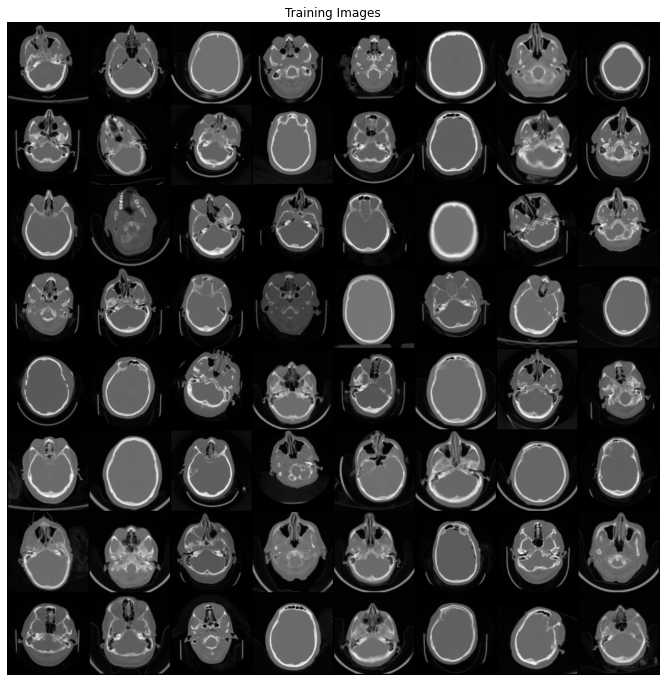

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
class ImageFolderReturnPaths(ImageFolder):
    def __getitem__(self, index):
        return super(ImageFolderReturnPaths, self).__getitem__(index) + (self.imgs[index][0],)

dataset = ImageFolderReturnPaths(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5], [0.5])]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
path = real_batch.pop()

# Get image id, get label by image
# Labels = 0 for healthy, 1 for hemorrhage
ID = [file.split("/")[4][:-4] + "_any" for file in path]
labels = df[df['ID'].isin(ID)]['Label'].values

plt.figure(figsize=(12 ,12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        # Input is 102 -> concatenation of noise channels (100) and one-hot encoded labels (2)
        self.fc1 = nn.Linear(102, nz)
        # input is Z, going into a convolution
        self.convT1 = nn.ConvTranspose2d(nz, ngf * 16, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 16)
        self.relu1 = nn.ReLU(True)
        self.convT2 = nn.ConvTranspose2d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 8)
        self.relu2 = nn.ReLU(True)
        self.convT3 = nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 4)
        self.relu3 = nn.ReLU(True)
        self.convT4 = nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf * 2)
        self.relu4 = nn.ReLU(True)
        self.convT5 = nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(ngf)
        self.relu5 = nn.ReLU(True)
        self.convT6 = nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False)
        self.tan = nn.Tanh()
            
    def forward(self, x, labels):        
        # Concatenate conditional vector
        x = torch.cat((x.view(-1, 100), labels.float()), -1)
        x = self.fc1(x)
        
        # Proceed with forward
        x = self.convT1(x.view(-1, 100, 1, 1))
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.convT2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.convT3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.convT4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.convT5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.convT6(x)
        x = self.tan(x)
        return x
        

In [7]:
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (fc1): Linear(in_features=102, out_features=100, bias=True)
  (convT1): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (convT2): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (convT3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (convT4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU(inplace=True)
  (convT5): ConvTranspose2d(256, 128, kernel_size=(4,

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        
        self.conv1 = nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False)
        self.leakyRelu1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(ndf * 2)
        self.leakyRelu2 = nn.LeakyReLU(0.2, inplace=True)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 4)
        self.leakyRelu3 = nn.LeakyReLU(0.2, inplace=True)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 8)
        self.leakyRelu4 = nn.LeakyReLU(0.2, inplace=True)
        self.conv5 = nn.Conv2d(ndf * 8, ndf * 16, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 16)
        self.leakyRelu5 = nn.LeakyReLU(0.2, inplace=True)
        self.conv6 = nn.Conv2d(ndf * 16, 1, kernel_size=4, stride=1, padding=0, bias=False)
        # Input size 3 -> 1 column for previous layer's output + 2 for labels
        self.fc1 = nn.Linear(3, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x, labels):        
        x = self.conv1(x)
        x = self.leakyRelu1(x)    
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.leakyRelu2(x)    
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.leakyRelu3(x)    
        x = self.conv4(x)
        x = self.bn3(x)
        x = self.leakyRelu4(x)    
        x = self.conv5(x)
        x = self.bn4(x)
        x = self.leakyRelu5(x)    
        x = self.conv6(x)
        
        # Concatenate conditional vector
        try:
            x = torch.cat((x.view(-1, 1), labels.float()), -1).to(device)
            x = self.fc1(x)
        except:
            print(labels)
            print(labels.size())
            print(x)
            print(x.size())
        
        x = self.sig(x)
        return x
    

In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (leakyRelu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyRelu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyRelu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyRelu4): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, e

In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(size=(64, nz, 1, 1), device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [13]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
# Labels for images to generate, in this case all of the 
# hemorrhage class (all 1s)
labels_one = torch.ones(size=(64, 1))
labels_zero = torch.zeros(size=(64, 1))
labels = torch.cat([labels_zero, labels_one], dim=1).to(device)

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        path = data.pop()
        one_hot_labels = F.one_hot(torch.from_numpy(getLabels(path))).to(device)
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu, one_hot_labels)
        output = output.view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise, one_hot_labels)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), one_hot_labels).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, one_hot_labels).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise with labels
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise, labels).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/150][0/11]	Loss_D: 1.1279	Loss_G: 1.8815	D(x): 0.3780	D(G(z)): 0.0328 / 0.1777
[1/150][0/11]	Loss_D: 0.6423	Loss_G: 2.1958	D(x): 0.7060	D(G(z)): 0.2308 / 0.1206
[2/150][0/11]	Loss_D: 1.2075	Loss_G: 1.4878	D(x): 0.3835	D(G(z)): 0.0930 / 0.2538
[3/150][0/11]	Loss_D: 0.8309	Loss_G: 2.0610	D(x): 0.6733	D(G(z)): 0.3137 / 0.1558
[4/150][0/11]	Loss_D: 1.1105	Loss_G: 2.6630	D(x): 0.7307	D(G(z)): 0.5212 / 0.0964
[5/150][0/11]	Loss_D: 0.8961	Loss_G: 2.0634	D(x): 0.7002	D(G(z)): 0.3767 / 0.1446
[6/150][0/11]	Loss_D: 0.8863	Loss_G: 2.6378	D(x): 0.7777	D(G(z)): 0.4448 / 0.0874
[7/150][0/11]	Loss_D: 0.8652	Loss_G: 1.8049	D(x): 0.6025	D(G(z)): 0.2646 / 0.1852
[8/150][0/11]	Loss_D: 0.8838	Loss_G: 2.2529	D(x): 0.6807	D(G(z)): 0.3643 / 0.1175
[9/150][0/11]	Loss_D: 0.7761	Loss_G: 1.9381	D(x): 0.6843	D(G(z)): 0.2968 / 0.1584
[10/150][0/11]	Loss_D: 0.9208	Loss_G: 1.8111	D(x): 0.6782	D(G(z)): 0.3731 / 0.1855
[11/150][0/11]	Loss_D: 0.9318	Loss_G: 1.9433	D(x): 0.7240	D(G(z)): 0.4272 / 0.1669
[12/150][0/11]

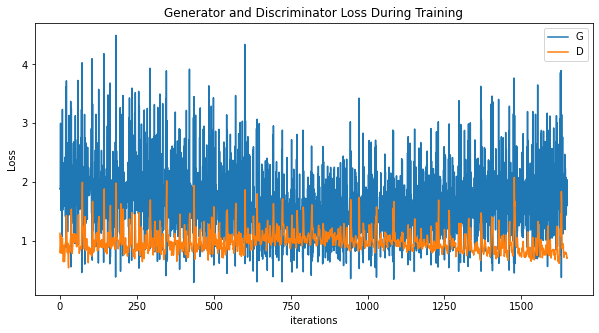

In [14]:
# Plot generator's and discriminator's loss during training
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

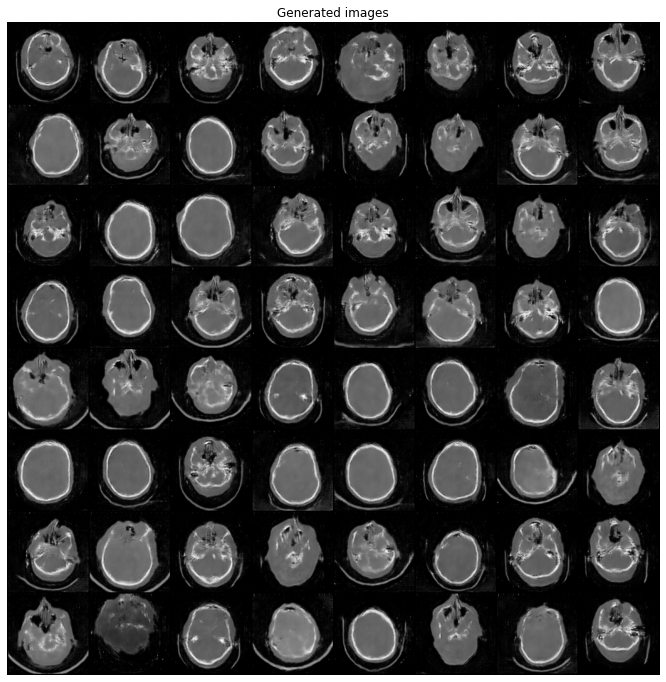

In [15]:
# Plot and save generated images
fig = plt.figure(figsize=(12, 12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
plt.title('Generated images')
plt.show()
for idx, img in enumerate(img_list):
  save_img('img_' + str(idx) + '.png', np.transpose(img, (1,2,0)))